In [1]:
import os, cv2, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-11-05 11:50:36.898297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762343437.079307      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762343437.130652      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.18.0
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
IMG_SIZE = (160, 160)
train_dir = "/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/train_data"
val_dir = "/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/val_data"

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

Found 380638 images belonging to 4000 classes.
Found 8000 images belonging to 4000 classes.


In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160,160,3))
base_model.trainable = False  # freeze base layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', name='embedding')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(base_model.input, output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1762343647.829229      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762343647.829968      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,613,920 (13.79 MB)

 Trainable params: 1,355,936 (5.17 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("/kaggle/working/classification_face_recognition.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762343658.824347      75 service.cc:148] XLA service 0x7a4fbc113040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762343658.824984      75 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762343658.825005      75 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762343659.670716      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


    1/11895 ━━━━━━━━━━━━━━━━━━━━ 40:31:23 12s/step - accuracy: 0.0000e+00 - loss: 8.2223

I0000 00:00:1762343663.827510      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11895/11895 ━━━━━━━━━━━━━━━━━━━━ 2463s 206ms/step - accuracy: 0.0026 - loss: 8.0027 - val_accuracy: 0.0137 - val_loss: 7.2046
Epoch 2/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 903s 76ms/step - accuracy: 0.0207 - loss: 6.9246 - val_accuracy: 0.0291 - val_loss: 6.7158
Epoch 3/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 832s 70ms/step - accuracy: 0.0363 - loss: 6.5597 - val_accuracy: 0.0417 - val_loss: 6.4941
Epoch 4/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 870s 73ms/step - accuracy: 0.0492 - loss: 6.3312 - val_accuracy: 0.0516 - val_loss: 6.3397
Epoch 5/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 884s 74ms/step - accuracy: 0.0599 - loss: 6.1620 - val_accuracy: 0.0601 - val_loss: 6.2289
Epoch 6/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 898s 76ms/step - accuracy: 0.0698 - loss: 6.0212 - val_accuracy: 0.0694 - val_loss: 6.1451
Epoch 7/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 883s 74ms/step - accuracy: 0.0776 - loss: 5.9211 - val_accuracy: 0.0705 - val_loss: 6.0941
Epoch 8/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 880s 74ms/step - acc

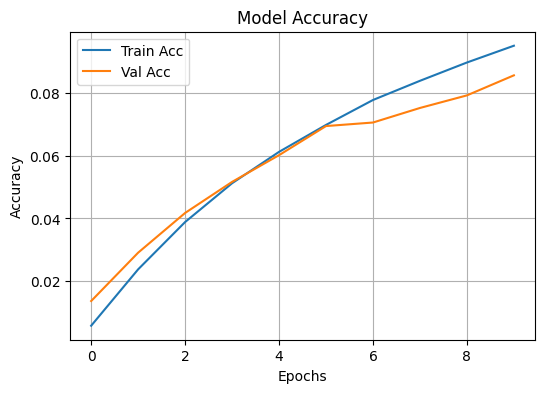

In [6]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)
plt.show()

In [7]:
embedding_model = Model(inputs=model.input,
                        outputs=model.get_layer('embedding').output)
embedding_model.save("/kaggle/working/embedding_extractor.h5")

print("Training complete and models saved to /kaggle/working/")

Training complete and models saved to /kaggle/working/
